# Introduction

The goal of this initial analysis is to load data about imports, exports, and domestic production of various food types, relevant to Switzerland. Please see the `README` for overall project goals and background information.

Note that in the current state of analysis, only fruits and vegetables have been considered. Functions for processing the data regarding meats, non-meat animal products, and other food groups have already been written, but this data was not yet incorporated into the notebook, for simplicity purposes and initial exploration.

In [170]:
# import external libraries
%matplotlib inline
import collections
import inspect
import pickle
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from networkx.algorithms import bipartite
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # prevents internal problem with networkx from showing error

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
# import local dependencies
import sys
sys.path.insert(1, "scripts")

from helpers import *
from plots import *
from impex_data_manipulation import *
from fao_data_manipulation import *
from emissions_data_manipulation import *
from data_analysis import *

The first step is to calculate, for each type of food, how much of what is consumed by the Swiss population is produced within Switzerland versus imported. To do this, we will combine 3 sets of data: imports, exports, and domestic production. The imports and exports data are sourced from [Swiss Impex](https://www.gate.ezv.admin.ch/swissimpex/index.xhtml), a website hosted by the Swiss Federal Customs Administration which provides data on Switzerland's global trade activity. Domestic production data comes from [FAOStat](http://www.fao.org/faostat/en/#data), the Food and Agriculture Organization of the United Nations which offers a variety of agricultural-related data. In theory, the amount of food consumed in Switzerland (including food waste) can be calculated from these datasets:

Food consumed = domestic production + imports - exports

Note that the Swiss Federal Statistics Office also provided relevant data--namely, it has a dataset on Swiss food consumption by type of food. Unfortunately, these data conflicted with the data from FAO and Swiss Impex. Since the Federal Statistics Office data was much less detailed (for instance, more general/broad food categories), we decided to focus on Impex and FAO, knowing that the numbers must be taken with a grain of salt since it is difficult to accurately quantify such data.

Let's load all the data and then combine the various data sets to get the values of interest. First we'll load imports and exports data from Impex. The data is spread across multiple Excel files and sheets.

***
**Data loading and manipulation**
***

Let's start with loading the Swiss Impex into the `impex` dataframe:

In [172]:
impex = load_impex()
impex.head()

type                     fruits                                          \
subtype    plantains_and_others             bananas               dates   
indicator               imports exports     imports  exports    imports   
total                 1444222.0     2.0  92397628.0  36763.0  2706334.0   
Argentina                 396.0     0.0         0.0      0.0        0.0   
Bangladesh                130.0     0.0         0.0      0.0        0.0   
Brazil                   1229.0     0.0      1301.0      0.0        0.0   
Cameroon                 1529.0     0.0     65786.0      0.0        0.0   

type                                                          ...    cereals  \
subtype                   figs           pineapples           ...     millet   
indicator   exports    imports  exports     imports  exports  ...    imports   
total       96471.0  3681429.0  56065.0  20809608.0  70821.0  ...  1069507.0   
Argentina       0.0     8783.0      0.0         0.0      0.0  ...        0.0   
Bangladesh      0.0        0.0      0.0         0.0      0.0  ...        0.0   
Brazil          0.0    42844.0      0.0       891.0      0.0  ...        0.0   
Cameroon        0.0        0.0      0.0    213628.0      0.0  ...        0.0   

type                                                                     \
subtype                   oats         cereals_nes                wheat   
indicator  exports     imports exports     imports exports      imports   
total       6450.0  25563410.0  6901.0    456430.0     0.0  214029783.0   
Argentina      0.0    251905.0     0.0         0.0     0.0   11787245.0   
Bangladesh     0.0         0.0     0.0         0.0     0.0          0.0   
Brazil         0.0         0.0     0.0         0.0     0.0          0.0   
Cameroon       0.0         0.0     0.0         0.0     0.0          0.0   

type                                  
subtype                fonio          
indicator    exports imports exports  
total       192496.0   319.0     0.0  
Argentina        0.0     0.0     0.0  
Bangladesh       0.0     0.0     0.0  
Brazil           0.0     0.0     0.0  
Cameroon         0.0     0.0     0.0  

[5 rows x 166 columns]

We then create a dataframe `impex_total` for storing total quantities for indicator variables:

In [173]:
# 1. Select only first row (total), creates a series
# 2. Unstack first level (indicator) to create a dataframe
impex_total = impex.iloc[0].unstack("indicator")
impex_total.head()

indicator                      exports     imports
type            subtype                           
animal_products butter       2085954.0    155312.0
                cheese      67285451.0  60637898.0
                eggs          442894.0  36298734.0
                honey         685704.0   8191947.0
                milk_cream  14990772.0  29234598.0

Let's now further manipulate the original `impex` dataframe to include information about the continents and sub-continents in the index:

In [174]:
# First we drop the total row
impex = impex.drop("total")

# Second, we load the country-continent info
countries = load_countries_continents()

# Finally, we compute the new index and apply it
countries_mindex = pd.MultiIndex.from_arrays(countries.values.T, names=countries.columns)
impex_mindex = countries_mindex[countries_mindex.get_level_values(2).isin(impex.index)]
impex.set_index(impex_mindex, inplace=True)

impex.index.names

FrozenList(['continent', 'subcontinent', 'country'])

Note that the `impex` frame should only contain information about food destined for humans. We were careful to ensure this was true: all items which can also be imported for the use of animal feed were selected by their subcategory of being specifically for human consumption. 

Now, let's load the data on Swiss domestic `production` from FAO:

In [175]:
production = load_fao()
production.head()

indicator                     production
type            subtype                 
animal_products butter      4.843600e+07
                cheese      2.063360e+08
                eggs        5.763500e+07
                honey       3.084000e+06
                milk_cream  4.795811e+09

In this data as well, we were careful that only crops produced for human consumption are measured. This is specified in the FAO metadata.

One interesting aspect of meat and non-meat animal product production, which is not relevant to the other food groups, is that animal feed may be sourced from a different location than where the meat/animal product is produced. This implicates the sourcing of animal feed as a very important factor for the carbon intensity of these foods. For example, if Switzerland produced most of its meat domestically, but it imported all of its feed, the carbon intensity of its meat would be much higher than if the feed were grown domestically. Thus, both aspects of the final food product must be examined.

In [176]:
# TODO decide how to handle animal feed

Next we perform an outer join of `impex_total` and `production` to create a meta-dataframe, `suisse` with all total macroeconomic indicators for each commodity subtype:

In [177]:
suisse = impex_total.join(production, how="outer")
suisse.head()

indicator                      exports     imports    production
type            subtype                                         
animal_products butter       2085954.0    155312.0  4.843600e+07
                cheese      67285451.0  60637898.0  2.063360e+08
                eggs          442894.0  36298734.0  5.763500e+07
                honey         685704.0   8191947.0  3.084000e+06
                milk_cream  14990772.0  29234598.0  4.795811e+09

We have three possibilities for each commodity
1. Neither production or import/export values are given or they all sum up to 0
2. Either only production values are given or only import/export values are given
3. Production, import and export values are all given (and are non-zero)

Commodities fulfilling the first condition will be removed. Commodities fulfilling the second or third condition will be kept.

<em style="font-size: 12px">Note: Missing or 0-valued data may be due to either the values actually being 0 or the data not being collected on these items. Since there is no way of knowing which is the case, we will assume that the values are indeed truly 0 to enable their utilization in the analysis.</em>

In [178]:
# Remove subtypes for which all given quantities sum up to 0
subtypes_no_info = suisse.index[suisse.sum(axis=1) == 0]
suisse.drop(subtypes_no_info, inplace=True)

Next, we shall add columns for `domestic_consumption` and `imported_consumption`.

Definitions:
* **domestic consumption**: goods and services consumed in the country where they are produced
* **imported consumption**: goods and services consumed in the country to which they are imported

**Note**: in this analysis we will make the following simplified assumptions:

* food waste is included as being "consumed"
* exported quantity is first satisfied by available produced quantity, and then imported quantity

In [179]:
# If exports > production, then we say all produced quantity
# is exported and the rest of exported quantity is satisfied by imports:
# 1. Set domestic_consumption to zero
# 2. Set imported_consumption to imports-(exports-production)

# If exports <= production, we say all exports
# is satisfied by domestic production: 
# 1. Set domestic_consumption to production-exports
# 2. Set imported_consumption to imports
suisse["domestic_consumption"] = np.where(
    suisse.exports > suisse.production,
    0,
    suisse.production - suisse.exports
)

suisse["imported_consumption"] = np.where(
    suisse.exports > suisse.production,
    suisse.imports - suisse.exports + suisse.production,
    suisse.imports
)

suisse["consumption"] = suisse.domestic_consumption + suisse.imported_consumption

suisse.head()

indicator                      exports     imports    production  \
type            subtype                                            
animal_products butter       2085954.0    155312.0  4.843600e+07   
                cheese      67285451.0  60637898.0  2.063360e+08   
                eggs          442894.0  36298734.0  5.763500e+07   
                honey         685704.0   8191947.0  3.084000e+06   
                milk_cream  14990772.0  29234598.0  4.795811e+09   

indicator                   domestic_consumption  imported_consumption  \
type            subtype                                                  
animal_products butter              4.635005e+07              155312.0   
                cheese              1.390505e+08            60637898.0   
                eggs                5.719211e+07            36298734.0   
                honey               2.398296e+06             8191947.0   
                milk_cream          4.780820e+09            29234598.0   

indicator                    consumption  
type            subtype                   
animal_products butter      4.650536e+07  
                cheese      1.996884e+08  
                eggs        9.349084e+07  
                honey       1.059024e+07  
                milk_cream  4.810055e+09

***
**Data analysis and visualization**
***

Let's plot imports and exports per meta-type:

In [180]:
# 1. Group by meta-type
# 2. Sum the totals
# 3. Unstack the columns to create a Series
impex_total_metatype = impex_total.groupby("type").sum().unstack()

In [181]:
impex_total_metatype

indicator  type           
exports    animal_products    168582740.0
           cereals              2723041.0
           fruits               4131495.0
           meat                 4940547.0
           vegetables           8819228.0
imports    animal_products    152945114.0
           cereals            309036367.0
           fruits             513223401.0
           meat                80153568.0
           vegetables         271520646.0
dtype: float64

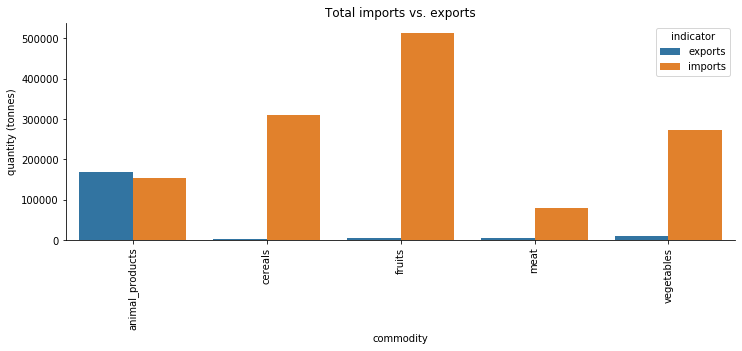

In [182]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=impex_total_metatype.index.get_level_values("type"),
    y=impex_total_metatype.values / 1000,  # kg --> tonnes
    hue=impex_total_metatype.index.get_level_values("indicator"),
)

ax.set(
    title="Total imports vs. exports", xlabel="commodity", ylabel="quantity (tonnes)"
)
plt.xticks(rotation=90)
sns.despine();

As you can see, Switzerland imports many more fruits, vegetables and meats than it exports. The `animal_products` category is interesting, because import and export quantities are about equal. What would make the most sense is if Switzerland imports different animal products than it exports (rather than the same products being both imported and exported). Let's test this theory by looking at imports and exports for the subcategories of `animal_products`:

In [183]:
impex_total_animal_prods = impex_total.loc["animal_products"].groupby("subtype").sum().unstack()

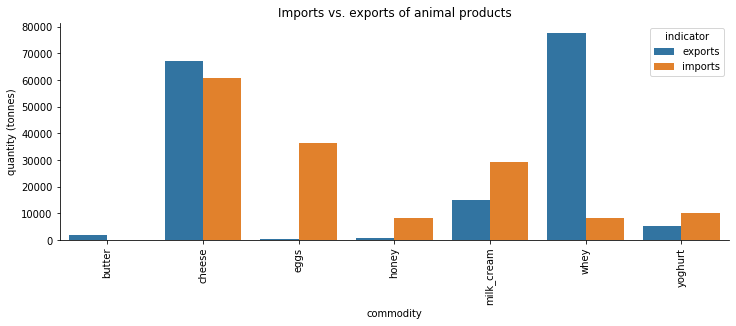

In [184]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=impex_total_animal_prods.index.get_level_values("subtype"),
    y=impex_total_animal_prods.values / 1000,  # kg --> tonnes
    hue=impex_total_animal_prods.index.get_level_values("indicator"),
)

ax.set(
    title="Imports vs. exports of animal products", xlabel="commodity", ylabel="quantity (tonnes)"
)
plt.xticks(rotation=90)
sns.despine();

This graph brings more light to the topic. Cheese, a category of which there are many different flavors and consumers like variety, is both heavily imported and exported, likely giving consumers access to a wider variety of cheese types. Eggs, on the other hand, are nearly exclusively imported, while whey is mostly exported.

The butter category of this graph is a good transition to the continuation of the analysis; just because butter is hardly imported nor exported does not mean the Swiss do not eat butter! Rather, imports and exports are only part of the broader picture since domestic production is another important consideration. One possible hypothesis for why butter is neither imported nor exported in large quantities is because domestic production is nearly equal to domestic consumption.

#### Bipartite graph between continents and meta food groups, weighted by amounts of food imported from those continents

In [186]:
continents = impex.index.get_level_values(0).unique().array
meta_food_groups = impex.columns.levels[0].array
bi = nx.Graph()
bi.add_nodes_from(continents, bipartite=1)
bi.add_nodes_from(meta_food_groups, bipartite=0)


# make an edge between each continent and each food group
edges = []
colors = ['red', 'blue', 'green', 'orange']
# for continent, color in zip(continents, colors):
#     for food in meta_food_groups:
#         edges.append((continent, food, color))
for continent in continents:
    for food in meta_food_groups:
        edges.append((continent, food))

        
bi.add_edges_from(edges, weight=3)

## Note from Brooke: there's something weird going on here. Doing `impex.xs('Africa')` only gives me 44 countries when there should be 66. I don't know why. Besides that, when I do all the code on one line for summing all fruit imports from Africa, I get a different number than if I do it in 3 lines. Will look at this later, for now just getting an idea of how to weight the edges.

In [187]:
african_fruits = impex.xs('Africa')['fruits']
african_fruits.xs('imports', level=1, axis=1)
african_fruits.to_numpy().sum()

477127301.0

In [188]:
impex.xs('Africa').fruits.xs('imports', level=1, axis=1).to_numpy().sum()
# notice that this is the same code but I get a different output than the cell above

473103969.0

In [189]:
continents = impex.index.get_level_values(0).unique().array
meta_food_groups = impex.columns.levels[0].array
weights = []

for continent in continents:
    for food in meta_food_groups:
        total_food_amount = impex.xs(continent)[food].xs('imports', level=1, axis=1).to_numpy().sum()
        weights.append(total_food_amount)

[148077713.0, 211169418.0, 473103969.0, 65839984.0, 243046408.0, 490436.0, 5321731.0, 30304139.0, 2647579.0, 21272193.0, 2418735.0, 68103249.0, 9449964.0, 11457942.0, 5519839.0, 1958230.0, 24441969.0, 365329.0, 208063.0, 1682206.0]


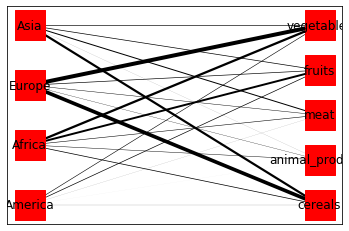

In [196]:
# change the weights of each edge
for num, name in enumerate(bi.edges(data=True)):
    name[2]['weight'] = weights[num]

# make a list of all the weights so can edit them
all_weights = []
for (node1,node2,data) in bi.edges(data=True):
    all_weights.append(data['weight'])

# normalize the weights so they are appropriate for the graph
for num, wt in enumerate(all_weights):
    all_weights[num] = wt*len(continents)/sum(all_weights)


top = nx.bipartite.sets(bi)[0]
pos = nx.bipartite_layout(bi, top)
nx.draw_networkx(bi, pos, font_size=12, node_size=900, node_color='red', node_shape='s', width=all_weights)

## Emissions


Now that we have calculated Switzerland's production and consumption, we want to have a look at how this translates in terms of equivalent CO$_2$ production. To do this, we could look at Swiss-specific values for the greenhouse gas production for different food types, however data from other countries is very sparse and reliable data for many food types is only available for certain countries. Later in the analysis, we want to compare Swiss production emissions with Swiss import emissions, therefore for consistency we need to either have data available for all (or most) countries for a given product, or use global averages. Comprehensive data is available on meat and cereal production emissions worldwide, however fruit and vegetable figures are much harder to obtain and only a limited number of studies have been carried out. These studies have been accumulated in a systematic review (https://www.sciencedirect.com/science/article/pii/S0959652616303584) and these values have been used to calculate averages for a number of different kinds of produce. To ensure our results are consistent, we will use this generalisation of global average values to estimate the domestic Swiss emissions for fruit and vegetables.

<!---
Other thought: I've currently created a dictionary to map the different fruit/veg to the impex categories. Was just thinking, this could be a potential spot to use machine learning, although admittedly not a very useful one...
--->

In [191]:
emissions = load_emissions()
emissions.head()

,Median,Mean,Stdev,Min,Max,Q1,Q3,No. of LCA studies,No. of GWP values
name,,,,,,,,,
almond/coconut milk,0.42,0.42,0.03,0.39,0.44,0.39,0.44,1.0,4.0
almonds,1.54,1.74,1.25,0.51,3.77,0.76,2.33,4.0,6.0
anglerfish,12.29,12.29,2.63,10.43,14.15,11.36,13.22,2.0,2.0
apples,0.29,0.36,0.19,0.18,0.89,0.21,0.47,21.0,33.0
apricots,0.43,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [192]:
# integrate the median emissions values into this dataframe
suisse = add_emissions_data(suisse, emissions)
suisse.head()

exports     imports   production  \
type            subtype                                        
animal_products butter    2085954.0    155312.0   48436000.0   
                cheese   67285451.0  60637898.0  206336000.0   
                whey     77624196.0   8145149.0   63000000.0   
                eggs       442894.0  36298734.0   57635000.0   
                honey      685704.0   8191947.0    3084000.0   

                         domestic_consumption  imported_consumption  \
type            subtype                                               
animal_products butter             46350046.0              155312.0   
                cheese            139050549.0            60637898.0   
                whey                      0.0            -6479047.0   
                eggs               57192106.0            36298734.0   
                honey               2398296.0             8191947.0   

                         consumption emissions_category  median_emissions  
type            subtype                                                    
animal_products butter    46505358.0             butter              9.25  
                cheese   199688447.0             cheese              8.55  
                whey      -6479047.0             cheese              8.55  
                eggs      93490840.0               eggs              3.46  
                honey     10590243.0              honey              0.00

So assuming that domestic transport is negligible, we can estimate the equivalent CO$_2$ emissions for each product type, using the global average values.

In [193]:
# calculate the emissions (resulting from production of the products)
suisse = production_emissions(suisse)
suisse.head()

exports     imports   production  \
type            subtype                                        
animal_products butter    2085954.0    155312.0   48436000.0   
                cheese   67285451.0  60637898.0  206336000.0   
                whey     77624196.0   8145149.0   63000000.0   
                eggs       442894.0  36298734.0   57635000.0   
                honey      685704.0   8191947.0    3084000.0   

                         domestic_consumption  imported_consumption  \
type            subtype                                               
animal_products butter             46350046.0              155312.0   
                cheese            139050549.0            60637898.0   
                whey                      0.0            -6479047.0   
                eggs               57192106.0            36298734.0   
                honey               2398296.0             8191947.0   

                         consumption emissions_category  median_emissions  \
type            subtype                                                     
animal_products butter    46505358.0             butter              9.25   
                cheese   199688447.0             cheese              8.55   
                whey      -6479047.0             cheese              8.55   
                eggs      93490840.0               eggs              3.46   
                honey     10590243.0              honey              0.00   

                         emissions_sans_transport  
type            subtype                            
animal_products butter               4.301746e+08  
                cheese               1.707336e+09  
                whey                -5.539585e+07  
                eggs                 3.234783e+08  
                honey                0.000000e+00

The final column of the above table shows the total CO$_2$ equivalent (kg) that would be produced if everything that was consumed in Switzerland was domestically produced, i.e. no transport emissions were considered and Swiss-specific CO$_2$ emissions were used for meat and cereal production. Evidently, it is not possible to produce everything that a current consumer buys locally, so in the following analysis we will consider the effect that these imported products and 'food miles' have on the CO$_2$ emissions resulting from Swiss consumption. 

## Transport Analysis

In [20]:
countries = country_distances()
countries.head()

,coord,distance_CH
country,,
Algeria,"[28.0000272, 2.9999825]",2136.0
Canary Islands,"[28.2935785, -16.6214471211441]",2983.0
Ceuta,"[35.888361, -5.304138]",1654.0
Ceuta/Melilla,"[36.7137977, -4.272712]",1525.0
Egypt,"[26.2540493, 29.2675469]",2938.0


## Further Analysis

The following will describe initial observations we have made regarding the transport of food, global carbon emissions intensities, and how we plan to use this information to estimate the impact consumption of different foods in Switzerland has and how a Swiss consumer can minimise their environmental impact in their food choices.

'Food miles', or the distance that food has to travel to arrive on your plate, clearly have an impact on the carbon emissions of the products we consume. Let's look at how much of the food, beverages, and tobacco that Switzerland imports comes from its nearest neighboring countries. The farther a country is, the more carbon emissions it would cost to import that food.

In [21]:
percentage = glimpse()
print(str(round(percentage)) + "% of Switzerland's total imports come from countries within a 1000km radius.")

76.0% of Switzerland's total imports come from countries within a 1000km radius.


So we can see that a lot of Switzerland's imports come from nearby countries. We will continue in this vein and look at the origins of each product individually to see the impact these food miles/varying production methods have on their carbon footprint. One thing we will consider is the transport methods, clearly the impact of these food miles differs greatly depending on whether the food is transported by plane or ship...

<img width="400" height="400" src="https://icmattermost.epfl.ch/files/5zr1jyriupfsfgmr4dtg155ssw/public?h=_GPk0xYK1I16gWsY3GuIsrFC5bTb3Ioh4_W3h3oYDs8">

Transport methods for different commodoties in the USA are described in detail in the paper *Food-Miles and the Relative Climate Impacts of Food Choices in the United States* (Weber and Matthews, 2008). These values, or similar data for other countries worldwide could be used to estimate the transport means for different products and thus the impact this transport has on emissions for each product. Perishable products more frequently have to be transported by air, and therefore have a significantly larger carbon footprint.